In [1]:
import os, sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [3]:
# from_h5 = True
from_h5 = False
from_slurm = not from_h5
'from_h5 = '+str(from_h5) if from_h5 else 'from_slurm = '+str(from_slurm)

'from_slurm = True'

In [ ]:
path = './'
path

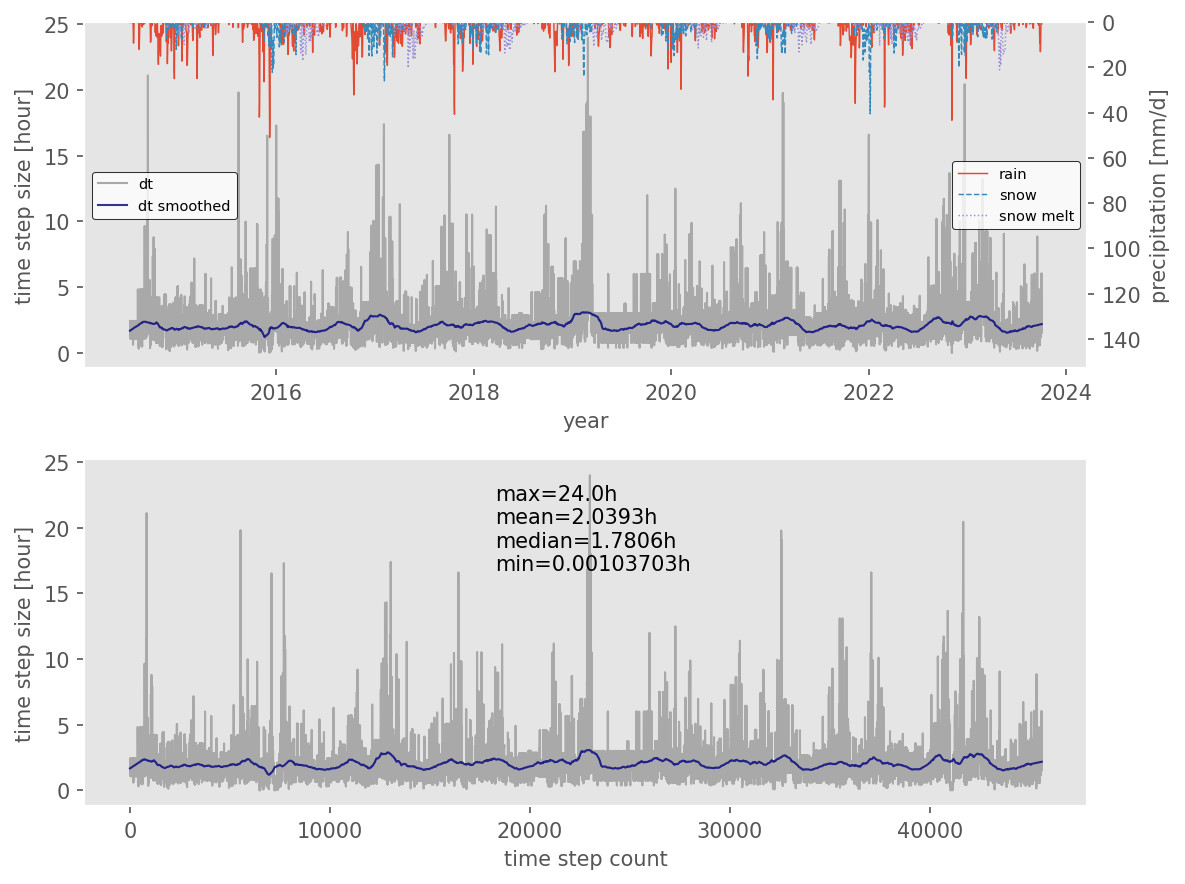

In [11]:
if from_h5:
    checkpointinterval = 100 # day
    fl = sorted(glob.glob(path+'checkpoint*'))
    fl.pop()
    dt = 100/np.diff(np.array([int(f.split('checkpoint')[1].split('.')[0]) for f in fl]))
    # t = pd.to_datetime(np.arange(len(dt))*10, unit='D', origin=pd.Timestamp('1980-07-04'))
    plt.plot(np.arange(len(dt))*checkpointinterval, dt*24, '-')
    plt.xlabel('time [day]')
    plt.ylabel(f'{checkpointinterval}-day averaged dt [hour]')
    plt.show()
elif from_slurm:
    plot_prcp = True
    os.system('grep Cycle '+path+'slurm* > dt.txt')
    with open('dt.txt', 'r') as f:
        ls = f.readlines()
        x, y = np.zeros(len(ls)), np.zeros(len(ls))
        for i,l in enumerate(ls):
            l = l.replace(' ','').split(']=')
            x[i] = l[1].split(',')[0]
            y[i] = l[2].split('\x1b')[0]
    os.system('rm dt.txt')

    d_to_h = 24
    d_to_m = d_to_h*60
    d_to_s = d_to_m*60
    fct = d_to_h
    
    x = x/365+1980
    y *= fct
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(x, y, color='darkgrey', label='dt')
    ax1.plot(x, savgol_filter(y, 1001, 1), color='navy', label='dt smoothed', alpha=0.8)
    # ax1.set_xlabel('time [d]')
    ax1.set_xlabel('year')
    ax1.set_ylabel('time step size [hour]')
    # ax1.set_xticks([2018.5, 2018.75, 2019, 2019.25], ['2018-07', '2018-10', '2019-01','2019-04'])
    # ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc='center left', edgecolor='k', facecolor='w')
    ax1.grid()
    if plot_prcp:
        w = pd.read_csv(path+'water_balance_computational_domain.csv', comment='#')
        w.iloc[:,0] = w.iloc[:,0]/365+1980
        ax = ax1.twinx()
        ax.plot(w.iloc[:,0], w.iloc[:,4]*1000, ls='-', lw=0.7, label='rain')
        ax.plot(w.iloc[:,0], w.iloc[:,5]*1000, ls='--', lw=0.7, label='snow')
        ax.plot(w.iloc[:,0], w.iloc[:,9]*1000, ls=':', lw=0.7, label='snow melt')
        ax.set_ylim(-0.1, np.max(w.iloc[:,4])*3*1000)
        ax.legend(loc='center right', edgecolor='k', facecolor='w')
        ax.set_ylabel('precipitation [mm/d]')
        ax.invert_yaxis()
        ax.grid()
    ax2.plot(y, color='darkgrey')
    ax2.plot(savgol_filter(y, 1001, 1), color='navy', alpha=0.8)
    ax2.set_xlabel('time step count')
    ax2.set_ylabel('time step size [hour]')
    ax2.ticklabel_format(useOffset=False)
    ax2.text(len(y)*0.4, (np.max(y)+np.min(y))*0.7, f'max={np.around(np.max(y),4)}h\nmean={np.around(np.mean(y),4)}h\nmedian={np.around(np.median(y),4)}h\nmin={np.around(np.min(y),8)}h')
    ax2.grid()
    plt.tight_layout()
    plt.show()